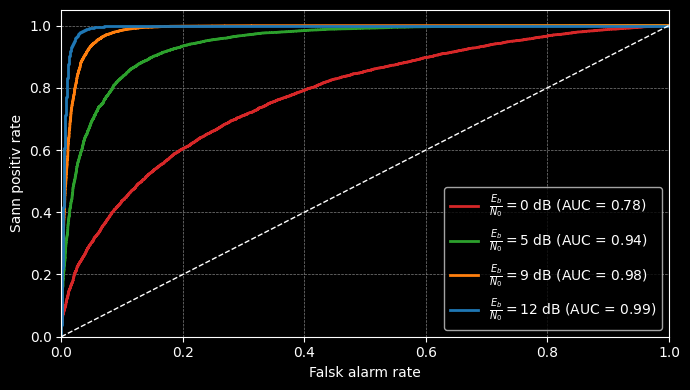

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.style.use('dark_background')

# --- Definer access-koden ---
access_code_bits_str = '1101100111001110'  # 16-bit din access-kode
access_code_bits = np.array([int(bit) for bit in access_code_bits_str])
access_code = 2 * access_code_bits - 1  # 0 -> -1, 1 -> 1

# --- Simuleringsparametre ---
num_trials = 10000
buffer_bits = 512
snr_db_list = [3, 8, 12, 15]  # SNR verdier i dB

# --- Start simulering ---
roc_curves = {}

for snr_db in snr_db_list:
    snr_linear = 10**(snr_db/10)

    true_labels = []
    scores = []

    for _ in range(num_trials):
        # --- Generer buffer ---
        random_bits = np.random.randint(0, 2, buffer_bits)
        random_code = 2 * random_bits - 1

        buffer_access = random_code.copy()

        # Sett inn access-koden på tilfeldig posisjon
        start_pos = np.random.randint(0, buffer_bits - len(access_code))
        buffer_access[start_pos:start_pos+len(access_code)] = access_code

        # Legg til støy
        noise_power = np.var(buffer_access) / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), size=buffer_access.shape)
        noisy_buffer_access = buffer_access + noise

        # Krysskorrelasjon
        cross_corr_access = np.correlate(noisy_buffer_access, access_code, mode='full')
        score = np.max(cross_corr_access)
        scores.append(score)
        true_labels.append(1)

        # --- False alarm ---
        random_bits_noise = np.random.randint(0, 2, buffer_bits)
        buffer_noise = 2 * random_bits_noise - 1

        noise_noise = np.random.normal(0, np.sqrt(noise_power), size=buffer_noise.shape)
        noisy_buffer_noise = buffer_noise + noise_noise

        cross_corr_noise = np.correlate(noisy_buffer_noise, access_code, mode='full')
        score_noise = np.max(cross_corr_noise)
        scores.append(score_noise)
        true_labels.append(0)

    # --- Beregn ROC ---
    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    roc_curves[snr_db] = (fpr, tpr, roc_auc)

# --- Plot alle ROC-kurver ---
plt.figure(figsize=(7,4))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors = colors[::-1]
for i, snr_db in enumerate(snr_db_list):
    fpr, tpr, roc_auc = roc_curves[snr_db]
    plt.plot(fpr, tpr, lw=2, label=r'$\frac{E_b}{N_0}=$'+f'{snr_db-3} dB (AUC = {roc_auc:.2f})', color=colors[i])

plt.plot([0,1], [0,1], color='white', linestyle='--', lw=1)  # Diagonal = tilfeldig gjetting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsk alarm rate')
plt.ylabel('Sann positiv rate')
#plt.title('ROC-kurve for access-kode ved ulike SNR-verdier')
plt.legend(loc='lower right')
plt.grid(linewidth=0.5, linestyle='--', color='gray')
plt.tight_layout()
plt.savefig('Figurer/ROC_FrameSync.pdf', bbox_inches='tight')
plt.show()